Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
!pip install pandas_profiling

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [5]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

**Taking care of imports**

In [6]:
!pip install category_encoders

In [7]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
from sklearn.linear_model import Ridge

#### Data Exploration

In [8]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [9]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

#### **Dropping EASE-MENT and APARTMENT_NUMBER**

In [10]:
df = df.drop(columns = ['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)
print(df.shape)
df.columns

(23040, 19)


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

## **1a. Use a subset of the data where One Family Dwellings (BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS')**

**Checking Building Class**

In [11]:
df['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
10 COOPS - ELEVATOR APARTMENTS                3471
13 CONDOS - ELEVATOR APARTMENTS               3339
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               366
17 CONDO COOPS                                 300
22 STORE BUILDINGS                             288
05 TAX CLASS 1 VACANT LAND                     288
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          147
08 RENTALS - ELEVATOR APARTMENTS               120
30 WAREHOUSES                                  105
21 OFFICE BUILDINGS                             96
31 COMMERCIAL VACANT LAND      

In [12]:
#BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
df_1 = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

In [13]:
df_1.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,A1,1193 SACKET AVENUE,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,A5,1215 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,A5,1211 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
42,3,OTHER,01 ONE FAMILY DWELLINGS,1,6809,54,A1,2601 AVENUE R,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,01/01/2019
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


## 1b. Use a subset of the data where the sale price was more than 100 thousand and less than $2 million

In [14]:
df_1 = df_1[df_1['SALE_PRICE'] < 2000000]
df_1 = df_1[df_1['SALE_PRICE'] > 100000]

**Checking SALE_PRICE is within the appropriate range**

In [18]:
print(min(df_1['SALE_PRICE']), max(df_1['SALE_PRICE']))

104000 1955000


In [16]:
df_1.shape

(3151, 19)

**Changing 'LAND_SQUARE_FEET' to an int**

In [17]:
df_1 = df_1.copy()
df_1['LAND_SQUARE_FEET'] = (
    df_1['LAND_SQUARE_FEET']
    .str.replace(',','')
    .astype(int)
)

## 2. Do train/test split. Use data from January - March 2019 to train. Use data from April 2019 to test.

**Chaning created by column into datetime format**

In [19]:
df_1['SALE_DATE'] = pd.to_datetime(df_1['SALE_DATE'], infer_datetime_format = True )

In [20]:
train = df_1[df_1['SALE_DATE'] < '04-01-2019']
test = df_1[df_1['SALE_DATE'] >= '04-01-2019']

**Checking that the test and train dataframes have the appropriate months**

In [21]:
min(train['SALE_DATE']), max(train['SALE_DATE']),min(test['SALE_DATE']), max(test['SALE_DATE'])

(Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-03-30 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-30 00:00:00'))

**Checking train/test shape**

In [22]:
print(train.shape, test.shape)

(2507, 19) (644, 19)


## 3. Do one-hot encoding of categorical features

**Checking relationships among the features**

In [23]:
train.corr()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
BLOCK,1.000000,0.048937,0.644818,-0.171459,-0.027522,-0.131137,-0.042277,-0.134267,-0.189535,NaN,-0.147684
LOT,0.048937,1.000000,-0.037589,-0.104133,-0.030540,-0.090103,-0.016217,-0.021153,0.050551,NaN,-0.047241
ZIP_CODE,0.644818,-0.037589,1.000000,-0.069325,0.045771,-0.009976,-0.125133,-0.073119,-0.434665,NaN,0.205550
RESIDENTIAL_UNITS,-0.171459,-0.104133,-0.069325,1.000000,0.014083,0.654053,0.195747,0.275252,0.048933,NaN,0.087763
COMMERCIAL_UNITS,-0.027522,-0.030540,0.045771,0.014083,1.000000,0.765585,-0.060545,0.155831,-0.092185,NaN,0.123074
TOTAL_UNITS,-0.131137,-0.090103,-0.009976,0.654053,0.765585,1.000000,0.080140,0.294987,-0.038256,NaN,0.149575
LAND_SQUARE_FEET,-0.042277,-0.016217,-0.125133,0.195747,-0.060545,0.080140,1.000000,0.388627,0.027204,NaN,0.278144
GROSS_SQUARE_FEET,-0.134267,-0.021153,-0.073119,0.275252,0.155831,0.294987,0.388627,1.000000,0.130416,NaN,0.454418
YEAR_BUILT,-0.189535,0.050551,-0.434665,0.048933,-0.092185,-0.038256,0.027204,0.130416,1.000000,NaN,-0.037376
TAX_CLASS_AT_TIME_OF_SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


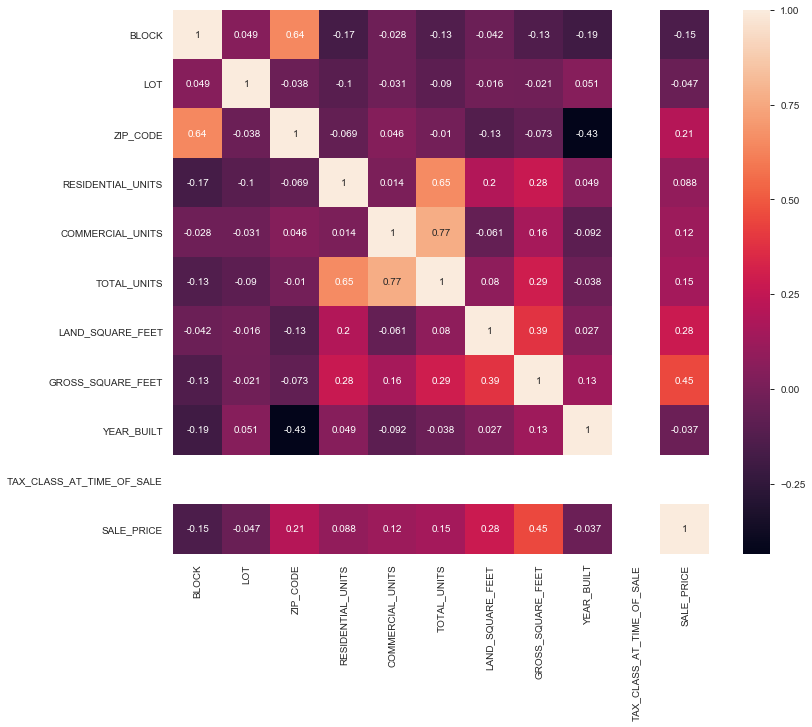

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(data = train.corr(), annot=True)

#https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

In [25]:
train.select_dtypes(include = 'number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2507.0,6758.303949,3975.909029,21.0,3837.5,6022.0,9888.5,16350.0
LOT,2507.0,75.778221,157.531138,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2507.0,10993.398484,494.291462,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2507.0,0.987635,0.110532,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2507.0,0.016354,0.129966,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2507.0,1.003989,0.171794,0.0,1.0,1.0,1.0,3.0
LAND_SQUARE_FEET,2507.0,3146.051057,1798.714872,0.0,2000.0,2600.0,4000.0,18906.0
GROSS_SQUARE_FEET,2507.0,1473.744715,599.217635,0.0,1144.0,1368.0,1683.0,7875.0
YEAR_BUILT,2507.0,1944.766653,27.059337,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2507.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


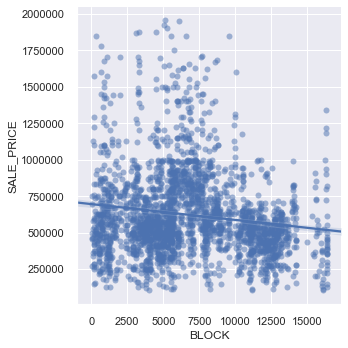

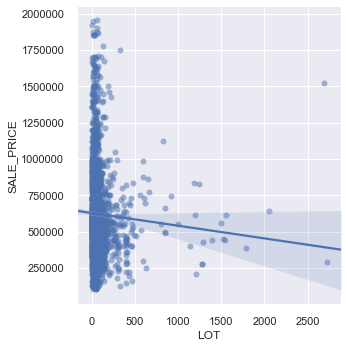

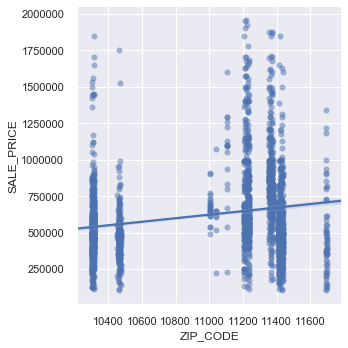

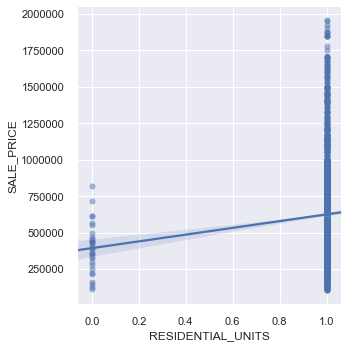

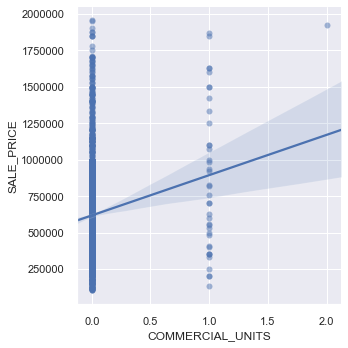

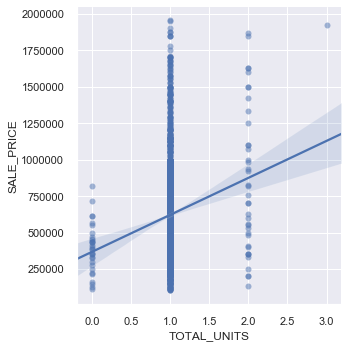

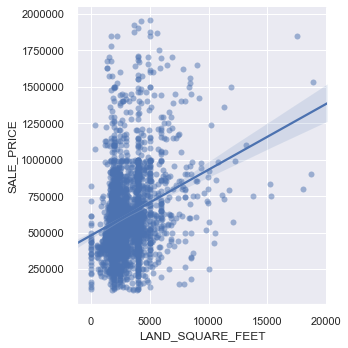

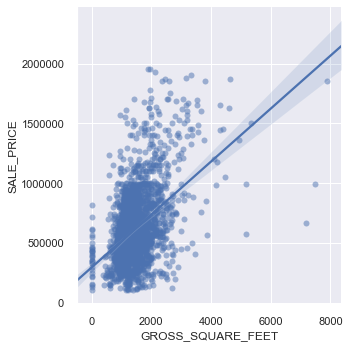

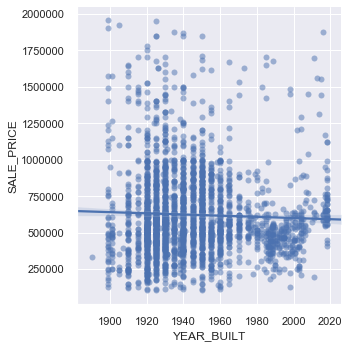

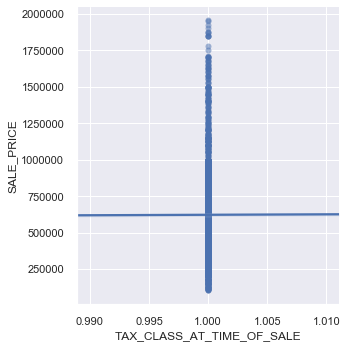

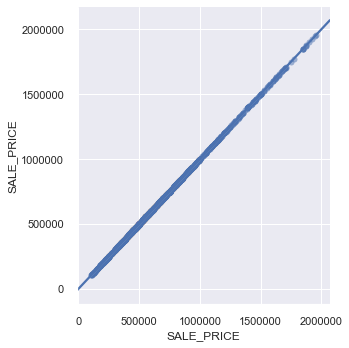

In [26]:
sns.set()

number = train.select_dtypes('number')

for col in number.columns:
  
  sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.5))
  plt.show()

In [27]:
train.select_dtypes(exclude = 'number').describe().T

,count,unique,top,freq,first,last
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,6,OTHER,2382,NaT,NaT
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
ADDRESS,2507,2497,130-52 LEFFERTS BOULEVARD,2,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


**Checking non-numeric columns relationship to price**

In [28]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    739000.000000
2    473104.623967
3    768734.633166
4    649005.172757
5    537305.802115
Name: SALE_PRICE, dtype: float64

In [29]:
import plotly.express as px

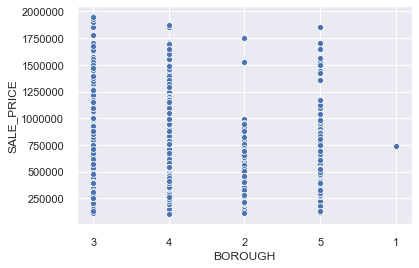

In [31]:
sns.scatterplot(x = 'BOROUGH', y = 'SALE_PRICE', data = train);

The relationship between price and borough is very interesting. You can see while most boroughs have some 1 family homes between 100,000 to 1million. Boroughs 3 and 4 seems to have the more listings that are greater than $1 million.

In [32]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
ASTORIA               1.001955e+06
BEDFORD STUYVESANT    6.215972e+05
BOROUGH PARK          1.008917e+06
FLUSHING-NORTH        8.689417e+05
FOREST HILLS          1.210753e+06
OTHER                 6.056645e+05
Name: SALE_PRICE, dtype: float64

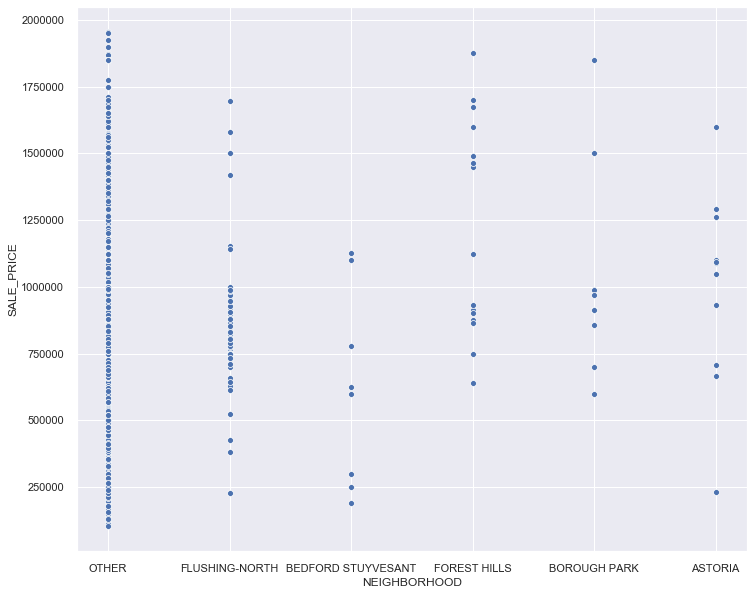

In [33]:
plt.figure(figsize = (12,10))
sns.scatterplot(x = 'NEIGHBORHOOD', y = 'SALE_PRICE', data = train);

In [34]:
train.groupby('TAX_CLASS_AT_PRESENT')['SALE_PRICE'].mean()

TAX_CLASS_AT_PRESENT
1     624436.781906
1D    392900.000000
Name: SALE_PRICE, dtype: float64

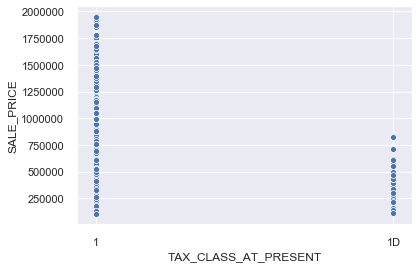

In [36]:
sns.scatterplot(x = 'TAX_CLASS_AT_PRESENT', y = 'SALE_PRICE', data = train);

It seems as if most of the higher priced properties are in the TAX_CLASS 1.

**Dropping columns and price**

In [37]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS','SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

**Checking X_train before encoding:**

In [38]:
print(X_train.shape)
X_train.head()

(2507, 16)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,A1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,A1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,A5


**OneHotEncoder**

In [39]:
encoder = ce.OneHotEncoder(use_cat_names = True)

#One-hot encoding
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
print(X_train.shape)
X_train.head()

(2507, 48)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,...,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## 4. Do feature selection with SelectKBest.
## 5. Fit a ridge regression model with multiple features. 
(Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
## 6. Get MAE for the test set

**Using loop to see what is the best features to select**

In [41]:
best_mae = []
mse = []
rmse = []
r2 = []
intercept = []

In [42]:
# Loop for selecting feature and getting linear regression data

for k in range(1, len(X_train.columns)+1):
  print(f'{k} features:')

  # SelectKBest
  selector = SelectKBest(score_func=f_regression, k=k)

  # Feature scaling 
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_test_selected = selector.transform(X_test_scaled)

  print(X_train.columns[:k])

  # Create linear regression model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  # Predict y for X test data
  y_pred = model.predict(X_test_selected)

  # Mean Absolute Error
  mae = mean_absolute_error(y_test, y_pred)
  print(f'TEST MAE: ${mae:,.0f}\n')
  

  #Test
  test_mse = mean_squared_error(y_test, y_pred)
  test_rmse = np.sqrt(test_mse)
  test_r2 = r2_score(y_test, y_pred)

  #Taking care of all my prints
  #Testing Data
  print('Test Data:')
  print(f'Test MSE: ${test_mse:.2f}')
  print(f'Test RMSE: ${test_rmse:.2f}')
  print(f'Test R^2: {test_r2:.2f} \n')

  #Model Interecept and Coefficients
  print('Model Intercept and Coefficients \n')
  print(f'Model intercept {model.intercept_} \n')
  print(f'Coefficients \n{(model.coef_)}')

  #Adding data to arrays
  best_mae.append(mae)
  mse.append(test_mse)
  rmse.append(test_rmse)
  r2.append(test_r2)
  intercept.append(model.intercept_)

1 features:
Index(['BOROUGH_3'], dtype='object')
TEST MAE: $183,641

Test Data:
Test MSE: $69121062299.79
Test RMSE: $262908.85
Test R^2: 0.22 

Model Intercept and Coefficients 

Model intercept 621573.7423214999 

Coefficients 
[132485.2427969]
2 features:
Index(['BOROUGH_3', 'BOROUGH_4'], dtype='object')
TEST MAE: $179,555

Test Data:
Test MSE: $67105172349.92
Test RMSE: $259046.66
Test R^2: 0.24 

Model Intercept and Coefficients 

Model intercept 621573.7423214999 

Coefficients 
[ 34871.94387874 118933.0648235 ]
3 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2'], dtype='object')
TEST MAE: $179,291

Test Data:
Test MSE: $66843669646.28
Test RMSE: $258541.43
Test R^2: 0.24 

Model Intercept and Coefficients 

Model intercept 621573.7423214999 

Coefficients 
[ 31358.28044211 112455.59382332  21227.09477426]
4 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5'], dtype='object')
TEST MAE: $179,365

Test Data:
Test MSE: $66896363070.18
Test RMSE: $258643.31
Tes

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package


Model intercept 621573.7423214996 

Coefficients 
[ 2.11051533e+04 -1.79538096e+05 -2.90175546e+05 -2.68816009e+04
  1.41767458e+04  2.81611663e+04 -1.97477369e+17 -2.40766367e+05
  5.15701036e+04  1.02648245e+05  1.97477369e+17]
12 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS'],
      dtype='object')
TEST MAE: $164,730

Test Data:
Test MSE: $53756379985.38
Test RMSE: $231854.22
Test R^2: 0.39 

Model Intercept and Coefficients 

Model intercept 621573.7423214996 

Coefficients 
[ 1.98894136e+04 -1.85935840e+05 -3.00774164e+05 -2.77801914e+04
  1.32706266e+04  2.69169084e+04 -7.67805908e+17 -2.51472536e+05
 -8.45816452e+03  5.15141929e+04  1.05503356e+05  7.67805908e+17]
13 features:
Index(['BOROUGH_3', 'B

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package


17 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9'],
      dtype='object')
TEST MAE: $156,352

Test Data:
Test MSE: $50914564856.09
Test RMSE: $225642.56
Test R^2: 0.42 

Model Intercept and Coefficients 

Model intercept 621573.7423214997 

Coefficients 
[ 1.81899100e+04 -1.32829148e+05 -2.07472741e+05 -1.20084630e+04
  1.25387035e+04  2.53512877e+04 -9.19195123e+04  1.02838327e+04
 -2.77848846e+18 -9.56680752e+04  1.06842012e+05 -5.67670669e+04
  6.01995492e+04  1.04230153e+05 -1.25145033e+04  2.77848846e+18
 -5.54211086e+04]
18 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0'],
      dtype='object')
TEST MAE: $156,425

Test Data:
Test MSE: $50936285445.79
Test RMSE: $225690.69
Test R^2: 0.42 

Model Intercept and Coefficients 

Model intercept 621573.7423214997 

Coefficients 
[ 2.07805769e+04 -1.34807846e+05 -2.07791594e+05 -1.50023574e+04
  1.31746027e+04  1.97470151e+04 -9.08386894e+04  6.83561701e+03
  4.88344548e+18 -7.73195929e+18  1.65771165e+15 -9.73932585e+04
  1.00207207e+05 -5.43056134e+04  5.99076866e+04  1.01372406e+

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4'],
      dtype='object')
TEST MAE: $154,862

Test Data:
Test MSE: $49791387137.44
Test RMSE: $223139.84
Test R^2: 0.43 

Model Intercept and Coefficients 

Model intercept 621380.2702680642 

Coefficients 
[ 1.14441551e+05  1.33328596e+05 -6.57735584e+04 -1.06036414e+05
  2.99127588e+04  4.38102899e+04  4.44630717e+04  

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package

TEST MAE: $81,123,936,680,226,544

Test Data:
Test MSE: $4238223957992120122849384315838529536.00
Test RMSE: $2058694721903206400.00
Test R^2: -48128743641629337661210624.00 

Model Intercept and Coefficients 

Model intercept 623585.2278665991 

Coefficients 
[ 7.46540269e+04  6.93768473e+04 -9.32786494e+04 -1.50661132e+05
  8.18492921e+04  8.61948266e+04  6.14450492e+04  4.19113481e+04
  3.37684401e+04 -7.71532634e+17  7.86021283e+17 -9.39893229e+04
  9.33639348e+03  1.75947295e+18 -1.52086007e+18 -1.29310444e+17
  6.67588621e+17  2.68515229e+18 -9.69160956e+04  5.50098243e+18
 -2.20322912e+18  4.23508696e+17  5.99351464e+04  1.05641145e+05
 -1.14632762e+04 -1.75947295e+18  3.31401760e+18  1.29310444e+17
  3.54832486e+18 -2.10647812e+18]
31 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK'

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package

TEST MAE: $6,197,663,626,577,414

Test Data:
Test MSE: $24736706170527363112005873518510080.00
Test RMSE: $157279070986979584.00
Test R^2: -280906955748428495192064.00 

Model Intercept and Coefficients 

Model intercept 621414.7658118756 

Coefficients 
[ 7.12501047e+04  7.04408736e+04 -9.01064826e+04 -1.42006074e+05
  9.27778869e+04  9.47366444e+04  6.50453750e+04  4.44929260e+04
  3.72590908e+04  1.09586223e+17 -1.06151378e+17 -9.36794822e+04
 -4.68060769e+03 -8.04569400e+15  8.64962926e+03  1.13916881e+15
  1.27526823e+18  2.15510358e+15  6.10627278e+15 -9.72260968e+16
  3.97374083e+17 -9.18189806e+04  4.06877671e+16 -2.08329479e+18
 -7.51650884e+17  6.05431122e+04  1.04687607e+05  8.04569400e+15
 -1.35442968e+04 -1.13916881e+15  1.25035992e+18 -2.15510358e+15
 -6.10627278e+15 -1.29959784e+17  4.17677431e+17]
36 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD S

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package

TEST MAE: $1,775,971,849,262,458

Test Data:
Test MSE: $2031224949681727549576386636152832.00
Test RMSE: $45069113034113816.00
Test R^2: -23066337657160464334848.00 

Model Intercept and Coefficients 

Model intercept 621786.881066594 

Coefficients 
[ 4.62159403e+04  2.99293860e+04 -9.68422299e+04 -1.70833537e+05
  7.99089181e+04  8.28431024e+04  5.83159178e+04  4.39950918e+04
  3.53190590e+04  3.98215059e+17  8.78354993e+17 -1.07890894e+05
 -3.42750987e+03  4.80665988e+18  8.25952786e+18  1.68577426e+18
  6.60740876e+18  1.48277879e+18  1.48866734e+18 -2.32342698e+16
  2.21016850e+18 -1.18790563e+17  3.56373300e+17  1.43416212e+18
  3.56373300e+17 -5.13356532e+04 -7.34705668e+17 -7.72586854e+17
 -4.06645374e+17  5.19111057e+04  1.02307153e+05  3.97353976e+04
  5.29333242e+18  4.76201595e+18  9.30343551e+17  1.51681433e+18
  7.45703391e+17  9.43390943e+17  1.99749464e+18  1.44946154e+18
 -7.30399263e+17  8.36756366e+17 -7.05649206e+17]
44 features:
Index(['BOROUGH_3', 'BOROUGH_4', 'BO

TEST MAE: $29,481,764,656,429,496

Test Data:
Test MSE: $559748344027676654614038047252021248.00
Test RMSE: $748163313740841344.00
Test R^2: -6356432510540935684161536.00 

Model Intercept and Coefficients 

Model intercept 621348.44333531 

Coefficients 
[ 3.99016580e+18  5.45502276e+18  3.22442962e+18  4.81324863e+18
  2.18022668e+17 -2.61107623e+18 -2.06986569e+18 -6.76584100e+17
 -9.84504714e+17 -8.27979461e+17 -7.92888828e+17 -1.26973649e+18
  2.31198477e+18 -3.30417440e+17 -1.02061545e+05 -3.52490510e+03
  1.43385657e+18  7.45070810e+17  5.22592724e+17 -7.26501646e+17
  4.18060669e+17 -1.97166101e+17 -6.29161453e+17 -1.30195716e+17
 -1.10370597e+18 -1.02245871e+18  2.25482735e+16 -6.25225159e+18
  2.25482735e+16 -5.62821129e+04  3.57081113e+18  7.38044306e+17
 -8.73937241e+18  6.01600000e+04  9.95520000e+04  3.73760000e+04
  0.00000000e+00 -1.31626016e+18 -5.32493588e+17 -3.18431001e+17
  7.97650194e+17 -2.55233754e+17  2.51065766e+17  6.27750711e+18
  1.61880709e+17  1.13658045e

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Users/jisha/opt/anaconda3/lib/python3.7/site-package

In [43]:
features_df = pd.DataFrame({'MAE':best_mae,'MSE':mse, 'RMSE':rmse, 'R2':r2, 'Intercept':intercept},
                           columns = ['MAE', 'MSE', 'RMSE', 'R2', 'Intercept'])
features_df

,MAE,MSE,RMSE,R2,Intercept
0,1.836406e+05,6.912106e+10,2.629088e+05,2.150698e-01,621573.742321
1,1.795548e+05,6.710517e+10,2.590467e+05,2.379620e-01,621573.742321
2,1.792915e+05,6.684367e+10,2.585414e+05,2.409316e-01,621573.742321
3,1.793653e+05,6.689636e+10,2.586433e+05,2.403332e-01,621573.742321
4,1.709298e+05,6.243031e+10,2.498606e+05,2.910492e-01,621573.742321
5,1.699234e+05,5.769054e+10,2.401886e+05,3.448734e-01,621573.742321
6,1.681233e+05,5.635658e+10,2.373954e+05,3.600217e-01,621573.742321
7,1.688845e+05,5.713860e+10,2.390368e+05,3.511412e-01,621573.742321
8,1.679562e+05,5.597461e+10,2.365895e+05,3.643593e-01,621573.742321
9,1.653453e+05,5.361018e+10,2.315387e+05,3.912094e-01,621573.742321


It seems that 20 features produces the best model.['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0']

**Fit a ridge regression model with multiple features.**

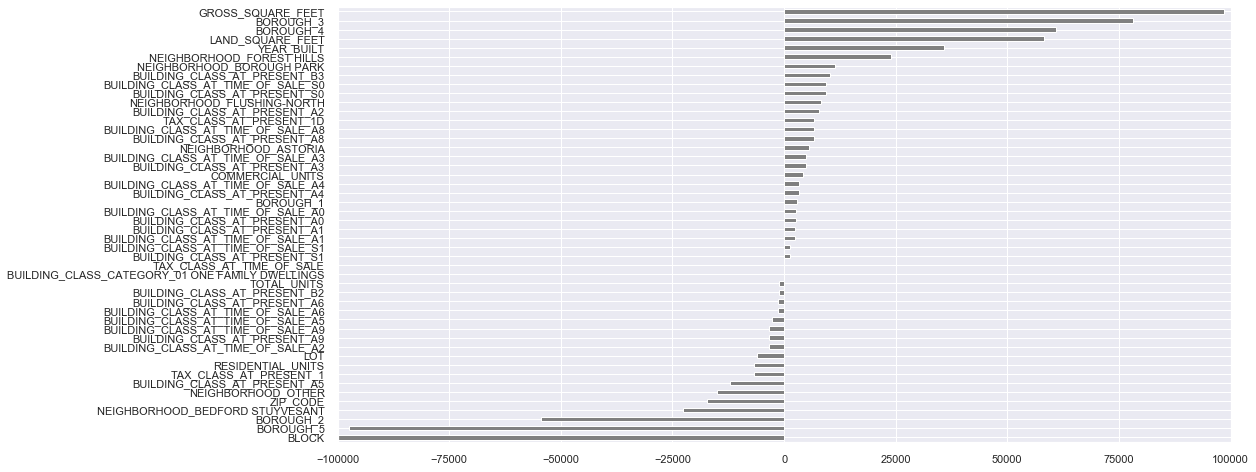

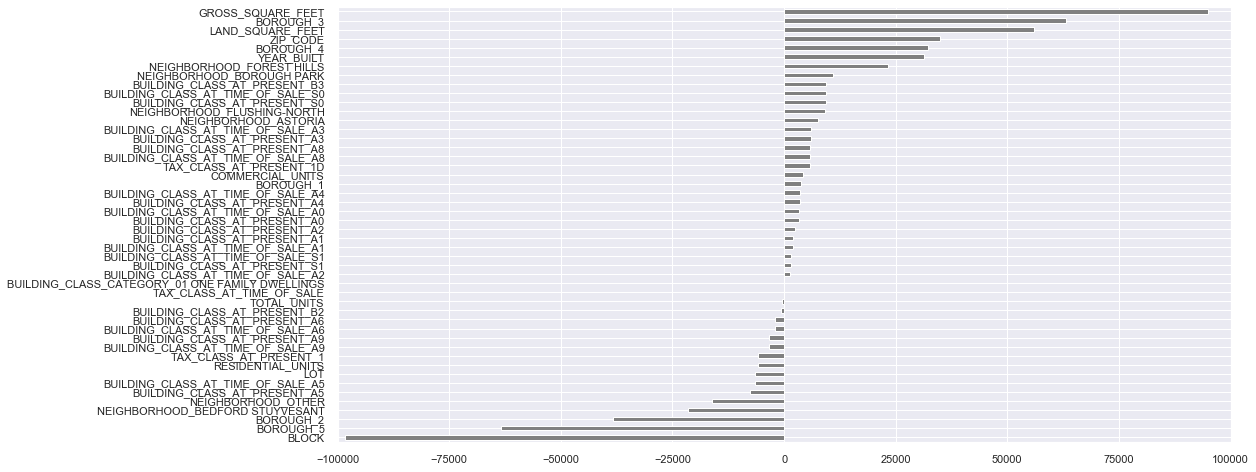

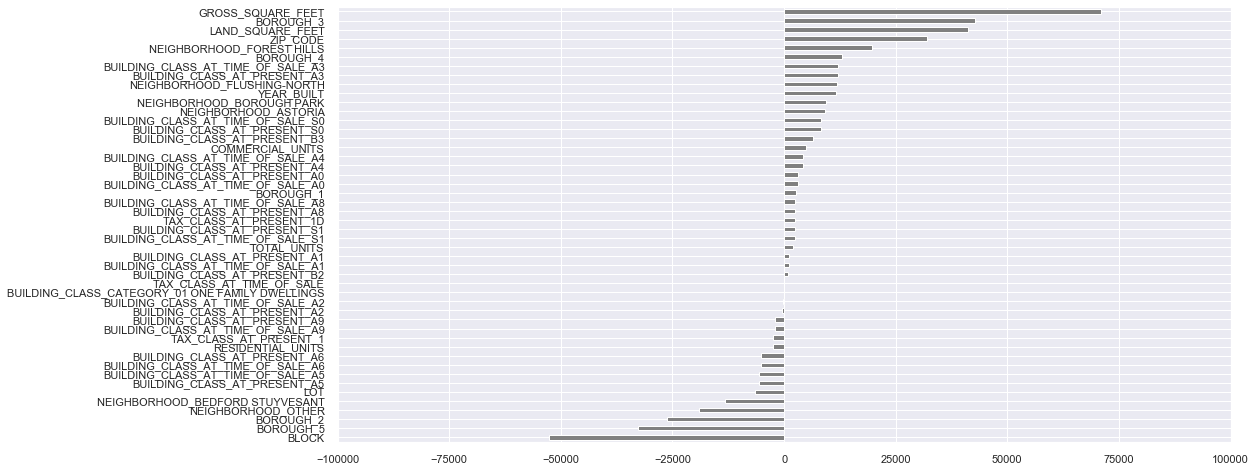

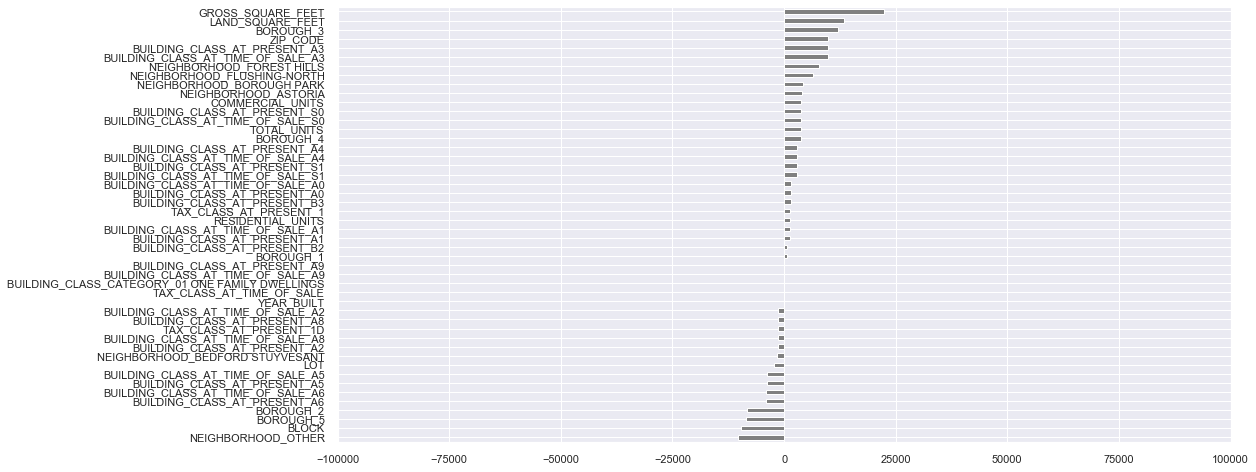

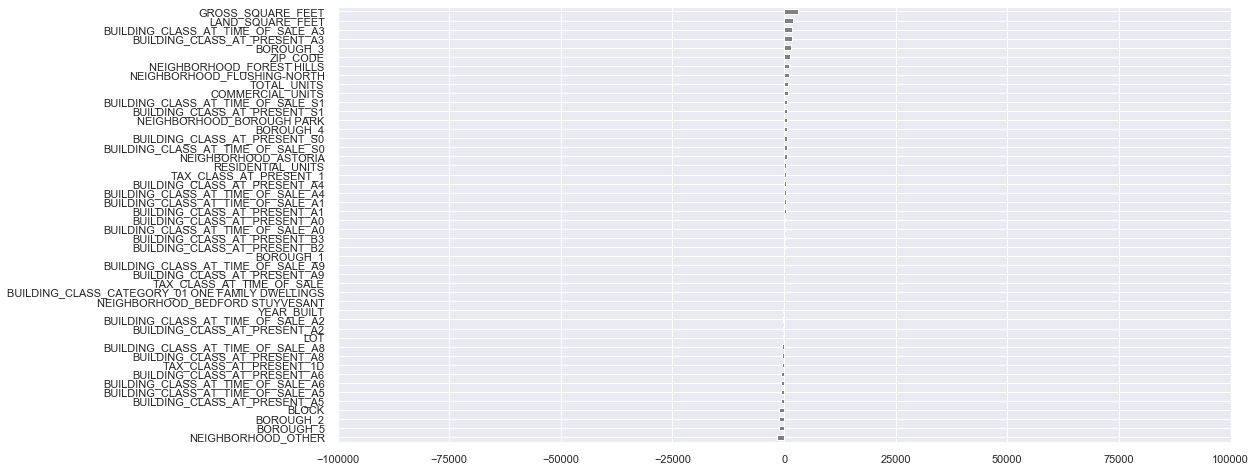

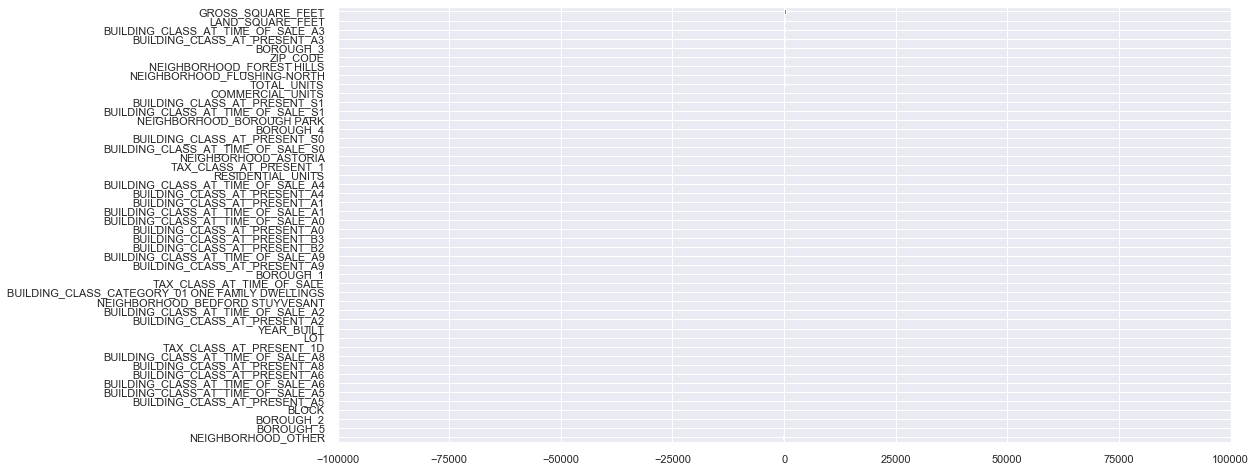

In [44]:
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6 ]:

  #Scale data before doing Ridge Regression
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #Fit Ridge Regression model
  display(HTML(f'Ridge Regression, with alpha{alpha}'))
  model = Ridge(alpha=alpha)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_selected)

  #Get Test MAE
  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  #Plot coefficients
  coefficients = pd.Series(model.coef_, X_train.columns)
  plt.figure(figsize = (16,8))
  coefficients.sort_values().plot.barh(color = 'grey')
  plt.xlim(-100000, 100000)
  plt.show()